<a href="https://colab.research.google.com/github/lisphilar/covid19-sir/blob/master/example/05_scenario_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scenario analysis
We will perform scenario anlysis. Regarding phase-dependent SIR-derived ODE models, this analysis focused on the impact of changes of ODE parameter values on the number of cases.

In [46]:
from datetime import timedelta
import pandas as pd
try:
    import covsirphy as cs
except ImportError:
    !pip install --upgrade "git+https://github.com/lisphilar/covid19-sir.git#egg=covsirphy" -qq
    import covsirphy as cs
cs.__version__

'2.24.0-tau'

## 1. Create analyser
An instance of `ODEScenario()` will be created here. We have two options as follows.

- With dataset of recommended servers
- With `pandas.DataFrame`

### 1.1 With dataset of recommended servers
We can create an instance with class method `ODEScenario.auto_build()` if the target dataset was registered in the recommended servers explained in [Data preparation]. As an example, we will use the dataset in Italy.

The following steps will be performed automatically and "Baseline" scenario will be registered.

Using `DataEngineer` class internally,
- Data downloading
- Data cleaning
- Data transformation
- Data subsetting
- Data complement (if necessary and selected)

Using `Dynamics` class internally,
- Time-series segmentation with S-R change point analysis
- Tau estimation
- ODE parameter estimation

In [47]:
snr_act = cs.ODEScenario.auto_build(geo="Italy", model=cs.SIRFModel, complement=True)


<SIR-F Model: parameter estimation>
Running optimization with 2 CPUs...
	2020-02-24 - 2020-03-22: finished   77 trials in 0 min  5 sec
	2020-11-04 - 2020-11-16: finished  141 trials in 0 min  9 sec
	2020-03-23 - 2020-04-10: finished  143 trials in 0 min 11 sec
	2020-11-17 - 2020-11-23: finished  129 trials in 0 min 10 sec
	2020-11-24 - 2020-11-30: finished   19 trials in 0 min  1 sec
	2020-12-01 - 2020-12-09: finished   84 trials in 0 min  5 sec
	2020-12-10 - 2020-12-18: finished   36 trials in 0 min  2 sec
	2020-12-19 - 2020-12-29: finished   68 trials in 0 min  4 sec
	2020-04-11 - 2020-05-05: finished  217 trials in 0 min 16 sec
	2020-12-30 - 2021-01-07: finished   84 trials in 0 min  5 sec
	2020-05-06 - 2020-08-28: finished  113 trials in 0 min 10 sec
	2021-01-08 - 2021-01-17: finished  244 trials in 0 min 17 sec
	2020-08-29 - 2020-09-25: finished  208 trials in 0 min 15 sec
	2021-01-18 - 2021-01-28: finished   92 trials in 0 min  6 sec
	2020-09-26 - 2020-10-12: finished   58 trial

We can perform simulation with `ODEScenario().simulate()` directly.

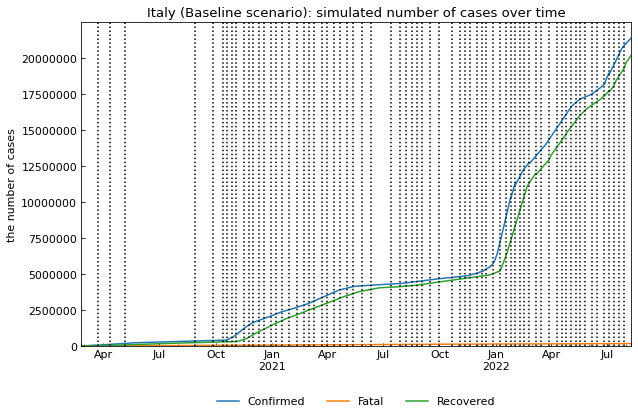

In [48]:
snr_act.simulate(name="Baseline");

Or, we can confirm the dynamics of the baseline senario, producing `Dynamics` instance.

,Start,End,Rt,theta,kappa,rho,sigma,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day]
Phase,,,,,,,,,,,
0th,2020-02-24,2020-03-22,7.95,0.033223,0.000545,0.017589,0.001593,0.033,122,4,42
1st,2020-03-23,2020-04-10,2.9,0.059198,0.000446,0.004776,0.001103,0.059,150,14,60
2nd,2020-04-11,2020-05-05,1.1,0.068807,0.000176,0.001837,0.001386,0.069,378,36,48
3rd,2020-05-06,2020-08-28,0.37,0.015582,0.000122,0.000876,0.00222,0.016,545,76,30
4th,2020-08-29,2020-09-25,2.96,0.000897,0.000025,0.002855,0.00094,0.001,2680,23,71
...,...,...,...,...,...,...,...,...,...,...,...
66th,2022-06-27,2022-07-03,2.68,0.001003,0.000006,0.010921,0.004063,0.001,11284,6,16
67th,2022-07-04,2022-07-11,2.73,0.003474,0.000006,0.008523,0.003107,0.003,10294,8,21
68th,2022-07-12,2022-07-20,1.74,0.001822,0.000006,0.006527,0.003728,0.002,11154,10,18


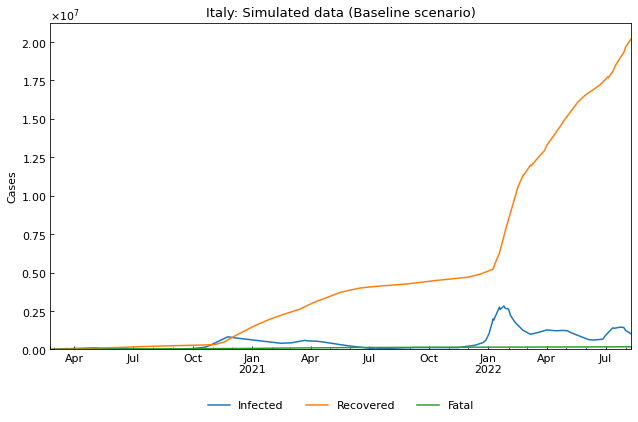

In [49]:
dyn_act = snr_act.to_dynamics(name="Baseline")
# Show summary
display(dyn_act.summary())
# Simulation
dyn_act_df = dyn_act.simulate(model_specific=False)
cs.line_plot(
    dyn_act_df.drop("Susceptible", axis=1), "Italy: Simulated data (Baseline scenario)")

If `name` is not specified, actual records will be shown.

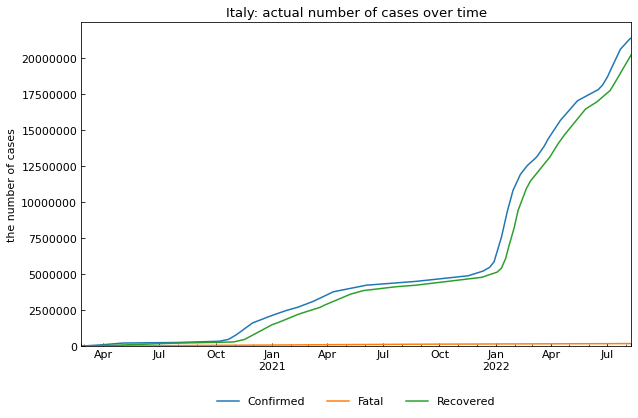

In [50]:
snr_act.simulate();

### 1.2 With `pandas.DataFrame`
The following solution is useful when we want to use `pandas.DataFrame` or sample data for scenario analysis.

At first, we will prepare an instance of `Dynamics`.

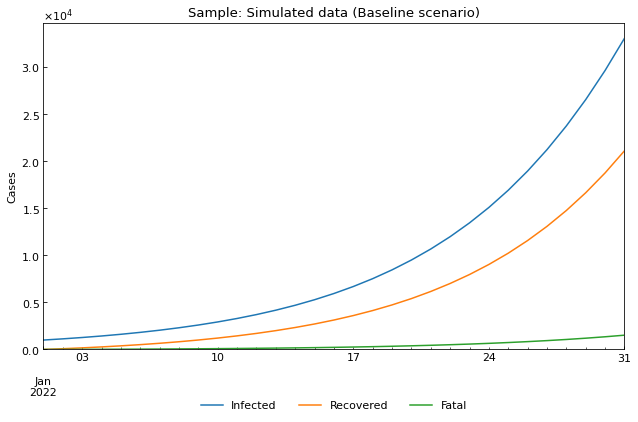

In [51]:
dyn_sample = cs.Dynamics.from_sample(cs.SIRFModel, date_range=("01Jan2022", "31Jan2022"), tau=1440)
sample_df = dyn_sample.simulate()
cs.line_plot(sample_df.drop("Susceptible", axis=1), "Sample: Simulated data (Baseline scenario)")

Then, prepare a `pandas.DataFrame` with time-index and Population/Confirmed/Recovered/Fatal columns. `DataEngineer` class will be useful.

In [52]:
eng = cs.DataEngineer(layers=["Country"])
df = sample_df.reset_index()
df.insert(0, "Country", "Sample")
eng.register(data=df)
eng.inverse_transform()
subset_df, *_ = eng.subset(
    geo="Sample", variables=["Population", "Confirmed", "Recovered", "Fatal"]
)
display(subset_df.head())
display(subset_df.tail())

,Population,Confirmed,Recovered,Fatal
Date,,,,
2022-01-01,1000000,1000,0,0
2022-01-02,1000001,1213,80,6
2022-01-03,1000000,1451,169,12
2022-01-04,999999,1720,271,19
2022-01-05,1000001,2025,385,28


,Population,Confirmed,Recovered,Fatal
Date,,,,
2022-01-27,1000000,35218,13068,940
2022-01-28,1000001,39544,14753,1061
2022-01-29,1000000,44357,16637,1196
2022-01-30,1000000,49704,18741,1347
2022-01-31,999999,55633,21088,1515


Finally, we can create an instance of `ODEScenario`.

In [53]:
snr = cs.ODEScenario(data=subset_df, location_name="Sample", complement=False)
snr.build_with_dynamics(name="Baseline", dynamics=dyn_sample)
# Confirm summar
snr.summary()

,,Start,End,Rt,theta,kappa,rho,sigma,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day],ODE,tau
Scenario,Phase,,,,,,,,,,,,,
Baseline,0th,2022-01-01,2022-01-31,2.5,0.002,0.005,0.2,0.075,0.002,200,5,13,SIR-F Model,1440


If we need to perform time-series segmentation, tau estimation and ODE parameter estimation, we can use `.build_with_model(name=<str>, model=<ODEModel>, data_range=<tuple of (str, str) or None>, tau=<int or None>` instead of `.build_with_dynamics()`.

## Set additional scenarios
We will define the following scenario as an example to analyze the impact of ODE parameter changes, copying the baseline scenario and add a phase with the changed ODE parameter values. Note that this is just an assumtion. It will be better to change ODE parameter values for your analysis.

| name | 01Jan - 31Jan | $\kappa$ (to 30Jun) | $\rho$ (to 30Jun) | $\sigma$ (to 30Jun) |
|:---:|:---:|:---:|:---:|:---:|
| Baseline | 100% | 100% | 100% | 100% |
| Lockdown | 100% | 100% |  50% | 100% |
| Medicine | 100% |  50% | 100% | 200% |
| Vaccine  | 100% |  60% |  80% | 120% |

Get the baseline values of ODE parameters.

In [54]:
df = snr.summary()
kappa, rho, sigma = df.loc[("Baseline", "0th"), ["kappa", "rho", "sigma"]]
print(f"kappa={kappa:.4}, rho={rho:.4}, sigma={sigma:.4}")

kappa=0.005, rho=0.2, sigma=0.075


### 2.1 Lockdown scenario
This scenario assumes that $\rho$ value will be decreased from 01Feb2022 because of stay-home restriction.

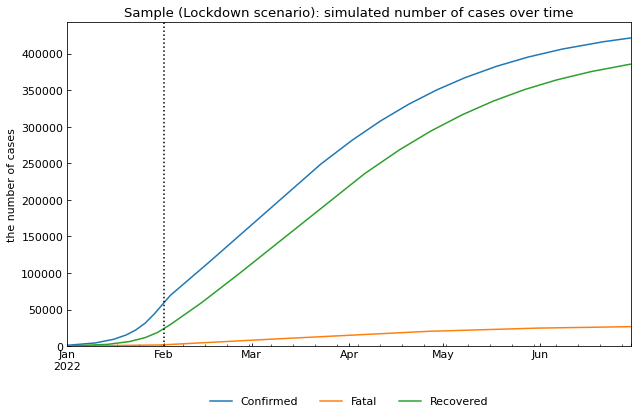

In [55]:
name = "Lockdown"
snr.build_with_template(name=name, template="Baseline")
snr.append(name=name, end="30Jun2022", rho=rho*0.5)
# Simulation
snr.simulate(name=name, v="01Feb2022");

### 2.2 Medicine senario
This scenario assumes that $\kappa$ will be decreased and $\sigma$ will be increased because of new medicine development.

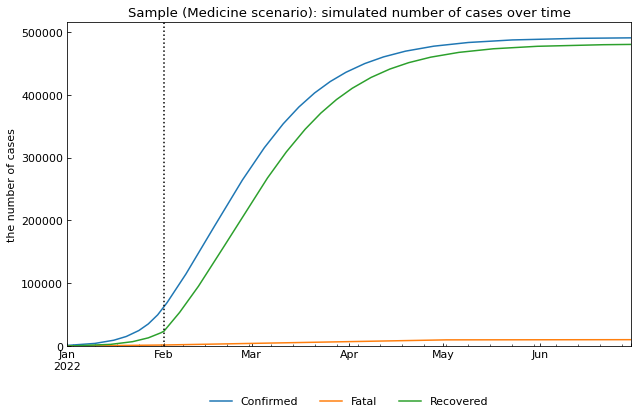

In [56]:
name = "Medicine"
snr.build_with_template(name=name, template="Baseline")
snr.append(name=name, end="30Jun2022", kappa=kappa*0.5, sigma=sigma*2)
# Simulation
snr.simulate(name=name, v="01Feb2022");

### 2.3 Vaccine scenerio
This scenario assumes that $\kappa$ and $\rho$ will be decreased and $\sigma$ will be increased because of vaccination.

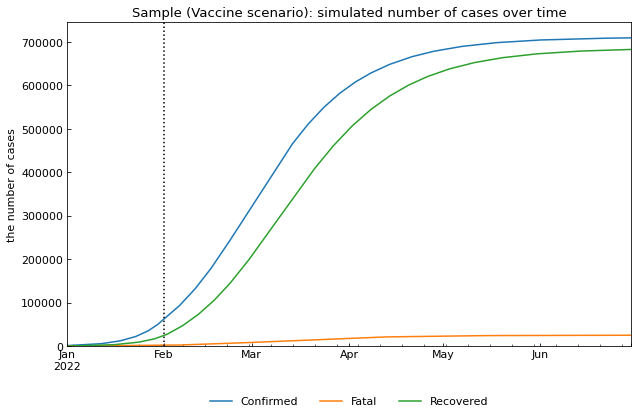

In [57]:
name = "Vaccine"
snr.build_with_template(name=name, template="Baseline")
snr.append(name=name, end="30Jun2022", kappa=kappa*0.6, rho=rho*0.8, sigma=sigma*1.2)
# Simulation
snr.simulate(name=name, v="01Feb2022");

### 2.4 Adjustment of the last dates
The last dates of the new scenarios are 30Jun2022, but the baseline scanrio ends on 31Jan2022. We need to extend the last phase to the baseline scenario analysis with `ODEScenario().append(name="Baseline")` or `ODEScenario().append()` (useful when we have some unchnaged scenarios).

Before appended:

In [58]:
snr.summary().style.applymap(lambda x: "background-color: yellow", subset=pd.IndexSlice[("Baseline", "0th"), "End"])

Append:

In [59]:
snr.append().summary().style.applymap(lambda x: "background-color: yellow", subset=pd.IndexSlice[("Baseline", "0th"), "End"])

If we need all values for dates, we can use `ODEScenario().track()` method.

In [60]:
snr.track()

,Scenario,Phase,Rt,theta,kappa,rho,sigma,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day],ODE,tau
Date,,,,,,,,,,,,,
2022-01-01,Baseline,0th,2.5,0.002,0.005,0.2,0.075,0.002,200,5,13,SIR-F Model,1440
2022-01-02,Baseline,0th,2.5,0.002,0.005,0.2,0.075,0.002,200,5,13,SIR-F Model,1440
2022-01-03,Baseline,0th,2.5,0.002,0.005,0.2,0.075,0.002,200,5,13,SIR-F Model,1440
2022-01-04,Baseline,0th,2.5,0.002,0.005,0.2,0.075,0.002,200,5,13,SIR-F Model,1440
2022-01-05,Baseline,0th,2.5,0.002,0.005,0.2,0.075,0.002,200,5,13,SIR-F Model,1440
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-26,Vaccine,1st,1.72,0.002,0.003,0.16,0.09,0.002,333,6,11,SIR-F Model,1440
2022-06-27,Vaccine,1st,1.72,0.002,0.003,0.16,0.09,0.002,333,6,11,SIR-F Model,1440
2022-06-28,Vaccine,1st,1.72,0.002,0.003,0.16,0.09,0.002,333,6,11,SIR-F Model,1440


## 3. Compare and evaluate scenarios

### 3.1 Compare the params
We will confirm the ODE parameter values and reproduction number with `ODEScenario().compare_param(param)` method.

Reproduction number:

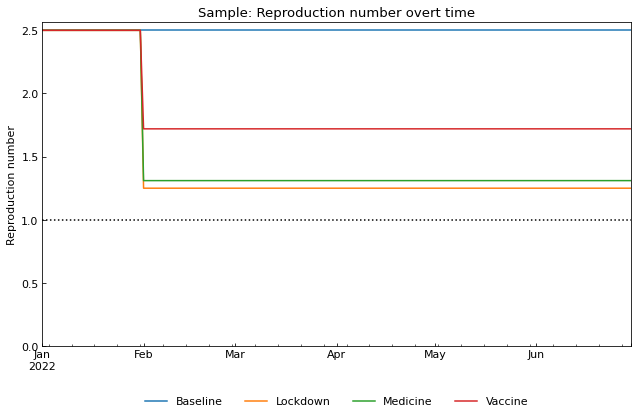

In [61]:
snr.compare_param("Rt");

ODE parameter values:

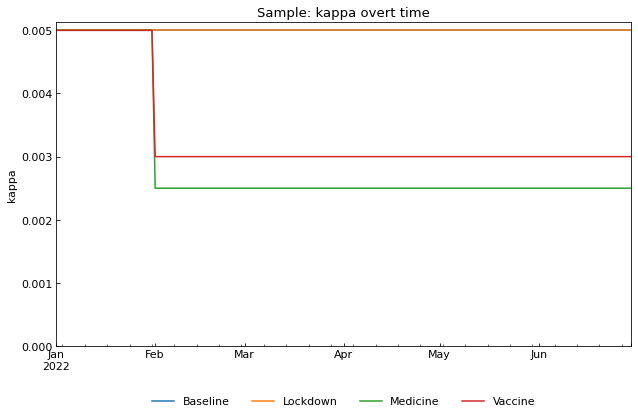

In [62]:
snr.compare_param("kappa");

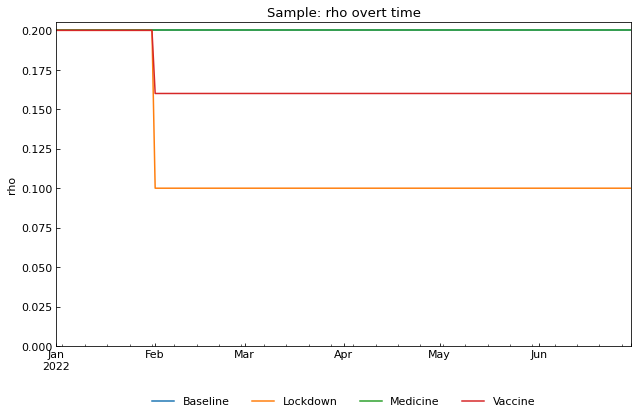

In [63]:
snr.compare_param("rho");

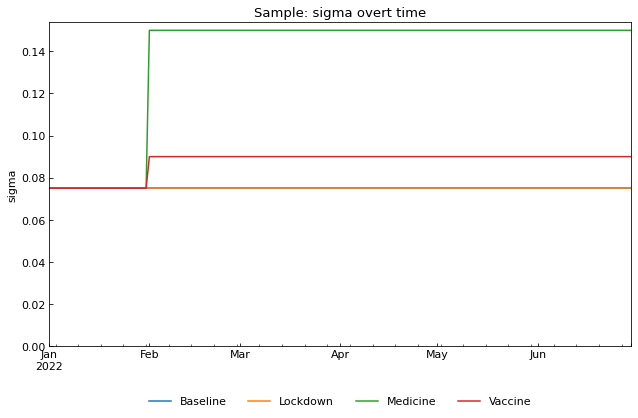

In [64]:
snr.compare_param("sigma");

### 3.2 Compare simulated number of cases
We will compare simulated number of cases with `ODEScenario().compare_cases(varialble, date_range=<None or tuple of dates>)` method.

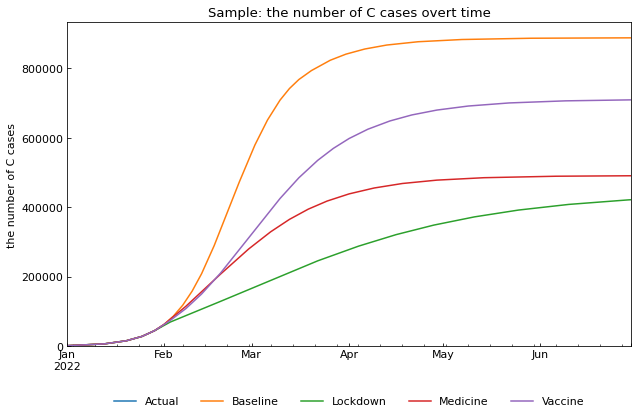

In [65]:
snr.compare_cases("Confirmed");

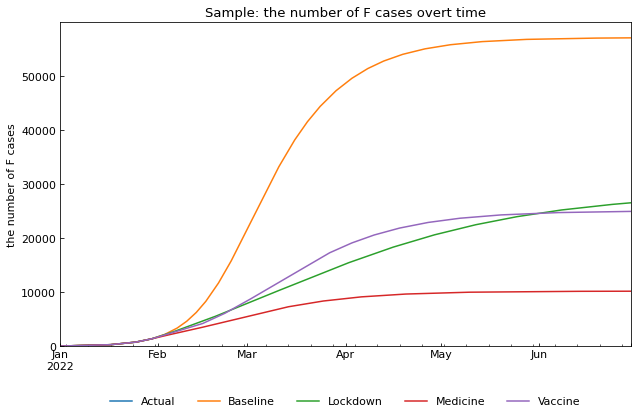

In [66]:
snr.compare_cases("Fatal");

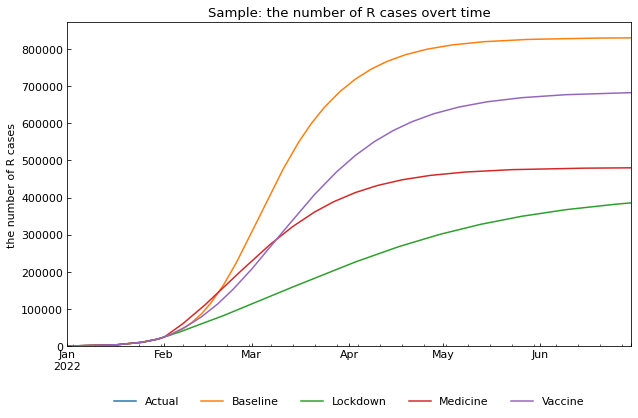

In [67]:
snr.compare_cases("Recovered");

### 3.3 Describe representative values
We can use `ODEScenario.describe()` to describe representative values of simulated number of cases. Max value of Infected and the number of cases on the last date will be shown as a `pandas.DataFrame`. Tjis is useful to confirm the impact of OE parameter changes.

In [68]:
snr.describe()

,max(Infected),argmax(Infected),Confirmed on 30Jun2022,Infected on 30Jun2022,Fatal on 30Jun2022
Baseline,232733,2022-03-03,887821,574,57116
Lockdown,47075,2022-03-09,421595,9267,26559
Medicine,53834,2022-02-22,490556,284,10166
Vaccine,114876,2022-03-10,709162,1720,24956


### 3.4 Get representative scenario
Which scenario is the best/worst scenario? Specifying quantile, variable name and date, we can confirm that with `ODEScenario().represent(q=<float or tuple of float>, variable=<str>, date=<str or None>, included=<list of str or None>, excluded=<list of str or None>)`. `date=None` means the last date of scenarios.

In [69]:
scenarios = snr.represent(q=(0.1, 0.9), variable="Confirmed", excluded=["Baseline"])
print(f" the best: {scenarios[0]} (small number of confirmed cases)\nthe worst: {scenarios[1]} (large number of confirmed cases)")

 the best: Lockdown (small number of confirmed cases)
the worst: Vaccine (large number of confirmed cases)


We can rename a scenario with `ODEScenario().rename(old, new)`.

In [70]:
snr.rename(old=scenarios[0], new="Best")
snr.rename(old=scenarios[1], new="Worst").describe()

,max(Infected),argmax(Infected),Confirmed on 30Jun2022,Infected on 30Jun2022,Fatal on 30Jun2022
Baseline,232733,2022-03-03,887821,574,57116
Medicine,53834,2022-02-22,490556,284,10166
Best,47075,2022-03-09,421595,9267,26559
Worst,114876,2022-03-10,709162,1720,24956


We can delete a scenario with `ODEScenario().delete(pattern, exact=True)`. Just for demonstration, we will delete the scenario which is not the baseline/best/worst scenario.

In [71]:
deleted_scenarios = [name for name in snr.describe().index.unique() if name not in [*scenarios, "Best", "Worst", "Baseline"]]
deleted_scenarios

['Medicine']

In [72]:
for name in deleted_scenarios:
    snr.delete(name, exact=True)
snr.describe()

,max(Infected),argmax(Infected),Confirmed on 30Jun2022,Infected on 30Jun2022,Fatal on 30Jun2022
Baseline,232733,2022-03-03,887821,574,57116
Best,47075,2022-03-09,421595,9267,26559
Worst,114876,2022-03-10,709162,1720,24956


We can delete scenarios with regular expressions with `ODEScenario().delete(pattern, exact=True)`. Just for demonstration, we will add scenarios which names start with "Deleted_". Then, delete them.

In [73]:
snr.build_with_template(name="Deleted_1", template="Baseline")
snr.build_with_template(name="Deleted_2", template="Baseline").describe()

,max(Infected),argmax(Infected),Confirmed on 30Jun2022,Infected on 30Jun2022,Fatal on 30Jun2022
Baseline,232733,2022-03-03,887821,574,57116
Best,47075,2022-03-09,421595,9267,26559
Worst,114876,2022-03-10,709162,1720,24956
Deleted_1,232733,2022-03-03,887821,574,57116
Deleted_2,232733,2022-03-03,887821,574,57116


In [74]:
snr.delete("Deleted_", exact=False).describe()

,max(Infected),argmax(Infected),Confirmed on 30Jun2022,Infected on 30Jun2022,Fatal on 30Jun2022
Baseline,232733,2022-03-03,887821,574,57116
Best,47075,2022-03-09,421595,9267,26559
Worst,114876,2022-03-10,709162,1720,24956


As explained, we can compare the scenarios with the methods, `ODEScenario().compare_cases()` as an example.

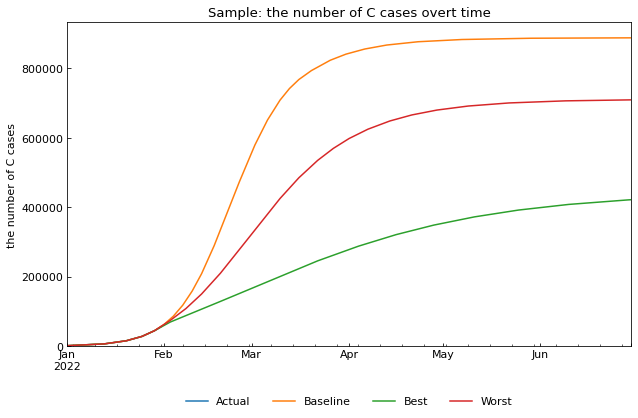

In [75]:
snr.compare_cases("Confirmed");

## 4. ODE parameter prediction
Here, we will predict the ODE parameter values using [AutoTS: a time series package for Python designed for rapidly deploying high-accuracy forecasts at scale](https://github.com/winedarksea/AutoTS).

`ODEScenario().predict(days, name, **kwargs)` creates scenarios and append a phase, performing prediction ODE parameter prediction for given days. The keyword arguments of `autots.AutoTS()` except for forecast_length (always the same as @days) can be applied.

Just for demonstation, we will use actual records in Italy.

In [76]:
snr_act.build_with_template(name="Predicted", template="Baseline")
snr_act.predict(days=30, name="Predicted");

Using 1 cpus for n_jobs.
Model Number: 1 with model AverageValueNaive in generation 0 of 1
Model Number: 2 with model AverageValueNaive in generation 0 of 1
Model Number: 3 with model AverageValueNaive in generation 0 of 1
Model Number: 4 with model GLS in generation 0 of 1
Model Number: 5 with model GLS in generation 0 of 1
Model Number: 6 with model LastValueNaive in generation 0 of 1
Model Number: 7 with model LastValueNaive in generation 0 of 1
Model Number: 8 with model LastValueNaive in generation 0 of 1
Model Number: 9 with model LastValueNaive in generation 0 of 1
Model Number: 10 with model SeasonalNaive in generation 0 of 1
Model Number: 11 with model SeasonalNaive in generation 0 of 1
Model Number: 12 with model SeasonalNaive in generation 0 of 1
Model Number: 13 with model ConstantNaive in generation 0 of 1
Model Number: 14 with model SeasonalNaive in generation 0 of 1
Model Number: 15 with model SeasonalNaive in generation 0 of 1
Model Number: 16 with model ConstantNaive i

Check the result of prediction.

In [77]:
future_start_date = snr_act.simulate(display=False).index.max() + timedelta(days=1)
future_start_date

Timestamp('2022-08-11 00:00:00')

In [78]:
df = snr_act.append().summary()
df.loc[df["Start"] >= future_start_date]

,,Start,End,Rt,theta,kappa,rho,sigma,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day],ODE,tau
Scenario,Phase,,,,,,,,,,,,,
Predicted,71st,2022-08-11,2022-09-09,1.15,0.000897,0.000008,0.004207,0.003645,0.001,8048,16,18,SIR-F Model,96


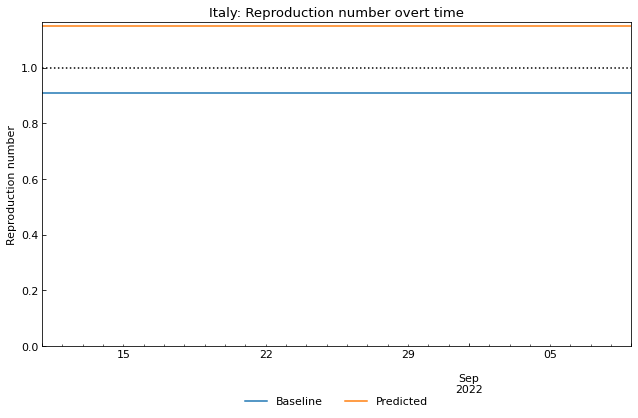

In [79]:
snr_act.compare_param("Rt", date_range=(future_start_date, None));

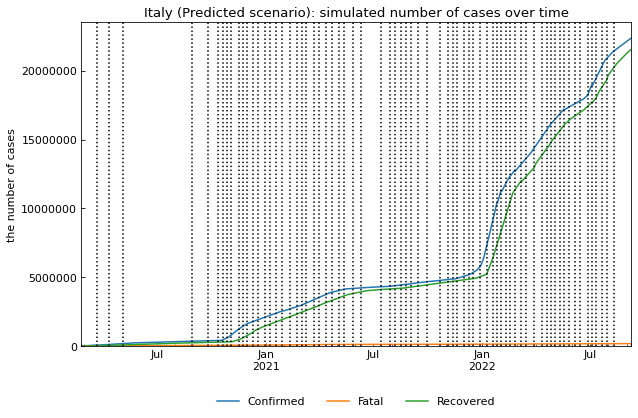

In [80]:
snr_act.simulate(name="Predicted");

In [81]:
snr_act.describe()

,max(Infected),argmax(Infected),Confirmed on 09Sep2022,Infected on 09Sep2022,Fatal on 09Sep2022
Baseline,2824171,2022-01-25,22130861,497607,178475
Predicted,2824171,2022-01-25,22384976,642075,178376


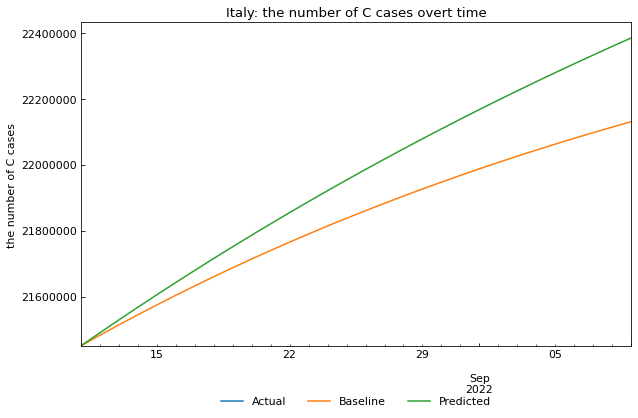

In [82]:
ymin_value = snr_act.compare_cases("Confirmed", date_range=(future_start_date, None), display=False).Predicted.min()
snr_act.compare_cases("Confirmed", date_range=(future_start_date, None), ylim=(ymin_value, None));

Note that minimum value of y in the figure was changed to focus on the diferences of the scenarios.

Thank you!